In [1]:
from predict import predict_labels
from wettbewerb import load_references, save_predictions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import display
from ecgdetectors import Detectors
import tensorflow as tf
from tensorflow import keras
import pylab
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from processData import process_Spectrogram
from filter_ecgToTest import filter as filter_ecg
from score import score
import tensorflow_addons as tfa

C:\Users\degin\anaconda3\envs\testkeras\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [37]:
ecg_leads, ecg_labels, fs, ecg_names = load_references('training')


6000	 Dateien wurden geladen.


In [151]:
#this is just to make the binary clasification
df=pd.DataFrame(data=dict(lables=ecg_labels))
df['ecg_signal']=ecg_leads
df = df[df.lables != 2]
df = df[df.lables != 3]
ecg_labelsBinary=df.lables.tolist()
ecg_leadsBinary=df.ecg_signal.tolist()
#this is only to test our progress by splitting into smaller test data
ecg_train, ecg_test, labels_train, labels_test = train_test_split(ecg_leadsBinary, ecg_labelsBinary, test_size=0.2,stratify=ecg_labelsBinary)
print('Number of trainings data:')
print(len(ecg_train))
print('Number of validation data:')
print(len(ecg_test))

Number of trainings data:
2929
Number of validation data:
733


In [38]:
for idx, ecg_lead in enumerate(ecg_leads):
    #ecg_leads[idx]=filter(ecg_leads[idx])
    ecg_leads[idx]=ecg_lead/np.amax(ecg_lead)
    
for idx, label in enumerate(ecg_labels):
    if label=="N":
        ecg_labels[idx]=0
    if label=="A":
        ecg_labels[idx]=1
    if label=="O":
        ecg_labels[idx]=2
    if label=="~":
        ecg_labels[idx]=3
        

In [39]:
# esto es para hacer la test data solo de 9000 de largo
minL=9000
ecgTemp=ecg_leads
for idx, ecg_lead in enumerate(ecg_leads):
    if len(ecg_lead)<minL:
        #removes the signals that are too short
        ecgTemp.pop(idx)
        ecg_labels.pop(idx)
#makes the signals be the same length
ecg_test=ecgTemp
for idx, ecg_lead in enumerate(ecgTemp):
    ecg_leads[idx]=ecg_lead[0:minL]
for idx, ecg_lead in enumerate(ecg_leads):
    if len(ecg_lead)<minL:
        #removes the signals that are too short
        ecgTemp.pop(idx)
        ecg_labels.pop(idx)
#makes the signals be the same length
ecg_test=ecgTemp
for idx, ecg_lead in enumerate(ecgTemp):
    ecg_leads[idx]=ecg_lead[0:minL]

In [40]:
ecg_train, ecg_test, labels_train, labels_test = train_test_split(ecg_leads, ecg_labels, test_size=0.2,stratify=ecg_labels)

In [26]:
#generate more data for the imbalanced dataset
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=888)
ecg_train, labels_train = sm.fit_resample(ecg_train, labels_train)


0


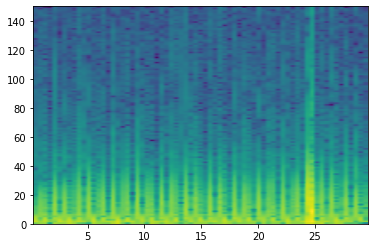

In [7]:
id=4
sig=ecg_train[id]
print(labels_train[id])
dedo=pylab.specgram(sig, Fs=fs)


In [27]:
#folders to save the processed data
OUTPUT_DIR='C:/Users/degin/Documents/AIProj/'
folder='ecg-2D_F1'
train_folder='/train'
val_folder='/validation'
pred_folder='/predict'
img_dir=os.path.join(OUTPUT_DIR,folder)
train_dir=img_dir+train_folder
val_dir=img_dir+val_folder
pred_dir=img_dir+pred_folder

In [7]:
#Takes a timeseries dataset and converts it to a 2D Spectrogram and saves it in a train/validation folder under classType_name_idx
import os
import pylab
def process_Spectrogram(output,folder_Name,folder_type,data,labels,freq):
    if not os.path.exists(os.path.join(output, folder_Name)):
        os.mkdir(os.path.join(output, folder_Name))
    if not os.path.exists(folder_type):
        os.mkdir(folder_type)
    for idx, ecg_lead in enumerate(data):
        if len(labels)==0:
            target_dir=f'class_x'
        else:
            target_dir=f'class_{labels[idx]}'
        if not os.path.exists(folder_type+'/'+target_dir):
            os.mkdir(folder_type+'/'+target_dir)
        #save the spectrogram as an png with the name: classType_name_index
        save_dir=target_dir+f'_ecg_{idx}'
        save_dir=os.path.join(target_dir,save_dir)
        save_path=os.path.join(folder_type,save_dir)

        pylab.specgram(ecg_lead, Fs=freq)
        pylab.savefig(f'{save_path}.png')
        pylab.close()

In [29]:
la=list()
len(la)


0

In [62]:
os.mkdir(val_dir)

In [41]:
#for the training data
process_Spectrogram(OUTPUT_DIR,folder,train_dir,ecg_train,labels_train,fs)
#for the validation data
process_Spectrogram(OUTPUT_DIR,folder,val_dir,ecg_test,labels_test,fs)
process_Spectrogram(OUTPUT_DIR,folder,pred_dir,ecg_test,la,fs)

0
0bilder bearbeit von4274
1000bilder bearbeit von4274
2000bilder bearbeit von4274
3000bilder bearbeit von4274
4000bilder bearbeit von4274
0
0bilder bearbeit von1069
1000bilder bearbeit von1069
0
0bilder bearbeit von1069
1000bilder bearbeit von1069


In [42]:
#this just creates the datasets from the train and valitation folders
HEIGHT=256
WIDTH=256
BATCH_SIZE=8
CHANNELS=3

train_data=tf.keras.preprocessing.image_dataset_from_directory(batch_size=BATCH_SIZE, directory=train_dir, color_mode='rgb',image_size=(HEIGHT,WIDTH),seed=0)
val_data=tf.keras.preprocessing.image_dataset_from_directory(batch_size=BATCH_SIZE, directory=val_dir, color_mode='rgb',image_size=(HEIGHT,WIDTH),seed=0)

Found 4274 files belonging to 4 classes.
Found 1069 files belonging to 4 classes.


In [248]:
cnn_model=tf.keras.models.Sequential()
cnn_model.add(tf.keras.layers.Input(shape=(HEIGHT, WIDTH,CHANNELS)))
#first layer
cnn_model.add(tf.keras.layers.Conv2D(32, 8, strides=4, padding='same',activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#first layer
cnn_model.add(tf.keras.layers.Conv2D(64, 4, strides=2, padding='same',activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#first layer
cnn_model.add(tf.keras.layers.Conv2D(128, 3, strides=1, padding='same',activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#first layer
cnn_model.add(tf.keras.layers.Conv2D(128, 3, strides=1, padding='same',activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(tf.keras.layers.Flatten())

#first dense layer
cnn_model.add(tf.keras.layers.Dense(512, activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
#second dense layer
cnn_model.add(tf.keras.layers.Dense(512, activation='softmax'))
cnn_model.add(tf.keras.layers.BatchNormalization())

#last layer
cnn_model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [226]:
#here goes the actual model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
#CNN
cnn_model=tf.keras.models.Sequential()
cnn_model.add(tf.keras.layers.Input(shape=(HEIGHT, WIDTH,CHANNELS)))
#first layer
cnn_model.add(tf.keras.layers.Conv2D(3, 11, strides=1, padding='same',activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.Conv2D(48, 5, strides=1, padding='same',activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))
#second layer
cnn_model.add(tf.keras.layers.Conv2D(128, 3, strides=1, padding='same',activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))
cnn_model.add(tf.keras.layers.Conv2D(128, 3, strides=1, padding='same',activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))
#third layer
cnn_model.add(tf.keras.layers.Conv2D(192, 3, strides=1, padding='same',activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.Conv2D(192, 3, strides=1, padding='same',activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.Conv2D(128, 3, strides=1, padding='same',activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#now the dense layers
cnn_model.add(tf.keras.layers.Flatten())
#cnn_model.add(tf.keras.layers.Dropout(0.5))
#first dense layer
cnn_model.add(tf.keras.layers.Dense(256, activation='softmax'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.Dense(512, activation='softmax'))
cnn_model.add(tf.keras.layers.BatchNormalization())

#last layer
cnn_model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [219]:
#here goes the actual model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
#CNN
cnn_model=tf.keras.models.Sequential()
cnn_model.add(tf.keras.layers.Input(shape=(HEIGHT, WIDTH,CHANNELS)))
#first layer
cnn_model.add(tf.keras.layers.Conv2D(32, 4, strides=2, padding='same',activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#second layer
cnn_model.add(tf.keras.layers.Conv2D(64, 4, strides=1, padding='same',activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#third layer
cnn_model.add(tf.keras.layers.Conv2D(128, 4, strides=1, padding='same',activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#now the dense layers
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dropout(0.5))
#first dense layer
cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
#second dense layer
cnn_model.add(tf.keras.layers.Dense(512, activation='softmax'))
cnn_model.add(tf.keras.layers.BatchNormalization())

#last layer
cnn_model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [249]:
#compile model
weights = {0: 2.,1: 50.,2: 5.,3: 1}
#cnn_model.compile(optimizer='adam', loss = tfa.losses.SigmoidFocalCrossEntropy() , metrics=['accuracy'])
cnn_model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [250]:
from keras import backend as K
K.set_value(cnn_model.optimizer.learning_rate, 0.0005)

In [251]:
cnn_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 64, 64, 32)        6176      
_________________________________________________________________
batch_normalization_110 (Bat (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 16, 16, 64)        32832     
_________________________________________________________________
batch_normalization_111 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 8, 8, 128)       

In [ ]:
# Train model for 10 epochs, capture the history
weights = {0: 2.,1: 100.,2: 2.,3: 1}
history = cnn_model.fit(train_data, epochs=20, validation_data=val_data,class_weight=weights)

Epoch 1/20
535/535 [==============================] - 5s 10ms/step - loss: 1.8273 - accuracy: 0.8486 - val_loss: 1.6832 - val_accuracy: 0.3414
Epoch 2/20
535/535 [==============================] - 5s 10ms/step - loss: 5.0299 - accuracy: 0.5477 - val_loss: 1.4349 - val_accuracy: 0.5098
Epoch 3/20
535/535 [==============================] - 5s 10ms/step - loss: 2.0182 - accuracy: 0.7108 - val_loss: 2.1315 - val_accuracy: 0.3527
Epoch 4/20
535/535 [==============================] - 5s 10ms/step - loss: 1.3971 - accuracy: 0.7777 - val_loss: 1.0717 - val_accuracy: 0.6539
Epoch 5/20
535/535 [==============================] - 5s 10ms/step - loss: 0.9713 - accuracy: 0.8477 - val_loss: 3.2665 - val_accuracy: 0.3433
Epoch 6/20
535/535 [==============================] - 6s 10ms/step - loss: 1.1027 - accuracy: 0.8381 - val_loss: 1.2982 - val_accuracy: 0.6389
Epoch 7/20
535/535 [==============================] - 5s 10ms/step - loss: 0.7622 - accuracy: 0.8804 - val_loss: 4.4994 - val_accuracy: 0.2825

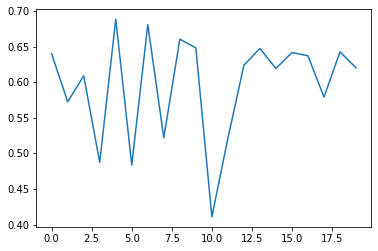

In [256]:
plt.plot(history.history['val_accuracy'])

In [134]:
#Save the model
# serialize model to JSON
model_json = cnn_model.to_json()
model_name='momoAdam_Huber.json'
model_name=os.path.join(img_dir,model_name)
weights_name='momoAdam_S.h5'
weights_name=os.path.join(img_dir,weights_name)
with open(model_name, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5

cnn_model.save_weights(weights_name)
print("Saved model to disk")

Saved model to disk


In [19]:
#load the model
# load json and create model
json_file = open(model_name, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_name)

In [236]:
#compile the model
cnn_model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [257]:
predict_data=tf.keras.preprocessing.image_dataset_from_directory(batch_size=BATCH_SIZE, directory=pred_dir, color_mode='rgb',image_size=(HEIGHT,WIDTH),seed=0)
classes = cnn_model.predict(predict_data)
#this sorts the predicted data and saves it in a tuple list
predictions=list()
for idx, ecg_lead in enumerate (classes):
    predictions.append(np.argmax(ecg_lead))
#this sorts the predicted data and saves it in a tuple list
predictions=list()
for idx, ecg_lead in enumerate (classes):
    predictions.append(np.argmax(ecg_lead))
#esto se engarga de guardar las predictions
labels_toTest=list()
for ecg in os.listdir(pred_dir+'/class_x'):
    ecg_idx=int(ecg.split("ecg_")[1].split(".")[0])
    ecg_class=predictions[ecg_idx]
    label2give="N"
    if int(ecg_class)==0:
        labels2give="N"
    elif int(ecg_class)==1:
        labels2give="A"
    elif int(ecg_class)==2:
        labels2give="O"
    else:
        labels2give="~"
    #esto es para el name
    labels_toTest.append((ecg.split("_",2)[-1].split('.')[0],labels2give))
#for true labels
labels_true=np.empty(len(predictions))
labels_names=list()
labels_toSave=list()
#this gets the labels of the training set
for fol in os.listdir(val_dir):
    for ecg in os.listdir(os.path.join(val_dir,fol)):
        #we iterate all the names of the validation data
        
        ecg_class=ecg.split('_',3)
        ecg_idx=ecg_class[3].split('.',1)
        ecg_idx=ecg_idx[0]
        ecg_class=ecg_class[1]
        labels_true[int(ecg_idx)]=int(ecg_class)
        label2give="N"
        if int(ecg_class)==0:
            labels2give="N"
        elif int(ecg_class)==1:
            labels2give="A"
        elif int(ecg_class)==2:
            labels2give="O"
        else:
            labels2give="~"
        #esto es para el name
        labels_toSave.append((ecg.split("_",2)[-1].split('.')[0],labels2give))
#save overall predictions
save_predictions(labels_toTest,pred_dir,"PREDICTIONS")
save_predictions(labels_toSave,pred_dir,"REFERENCE")
#plot score
score(pred_dir)

Found 1069 files belonging to 1 classes.
1069	 Labels wurden geschrieben.
1069	 Labels wurden geschrieben.


(0.13526570048309178,
 0.24773089073067803,
 {'N': {'n': 395, 'a': 105, 'o': 144, 'p': 1},
  'A': {'n': 54, 'a': 14, 'o': 20, 'p': 0},
  'O': {'n': 206, 'a': 34, 'o': 77, 'p': 0},
  'P': {'n': 10, 'a': 6, 'o': 3, 'p': 0}})

In [112]:
save_predictions(labels_toTest,pred_dir,"PREDICTIONS")
save_predictions(labels_toSave,pred_dir,"REFERENCE")

1069	 Labels wurden geschrieben.
1069	 Labels wurden geschrieben.


In [113]:
score(pred_dir)

(0.0,
 0.1881563593932322,
 {'N': {'n': 645, 'a': 0, 'o': 0, 'p': 0},
  'A': {'n': 88, 'a': 0, 'o': 0, 'p': 0},
  'O': {'n': 317, 'a': 0, 'o': 0, 'p': 0},
  'P': {'n': 19, 'a': 0, 'o': 0, 'p': 0}})